# Computing for Data Science Final Project Notebook - Predicting House Prices in Poland

### Team members: Angelo Di Gianvito, Joaquin Ossa, Oliver Gatland, Viktoriia Yuzkiv

Importing libraries

In [1]:
import Libraries.fplibrary.exploration as e
import Libraries.fplibrary.feature_engineering as f
import Libraries.fplibrary.loading_data as l
import Libraries.fplibrary.preprocessing as p
import Libraries.fplibrary.model as m
import pandas as pd 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import numpy as np
import warnings
warnings.simplefilter("ignore")

Loading data

In [2]:
data_loader = l.DataLoader('data/apartments_pl_2023.csv')
train_data, test_data = data_loader.load_and_split_data()

# Merge train and test data for data exploration and pre-processing
train_data['is_train']=1
test_data['is_train']=0

all_data = pd.concat([train_data,test_data]).reset_index()

### Data exploration

In [3]:
# Define plots class
plots = e.ExplorationPlots(all_data)

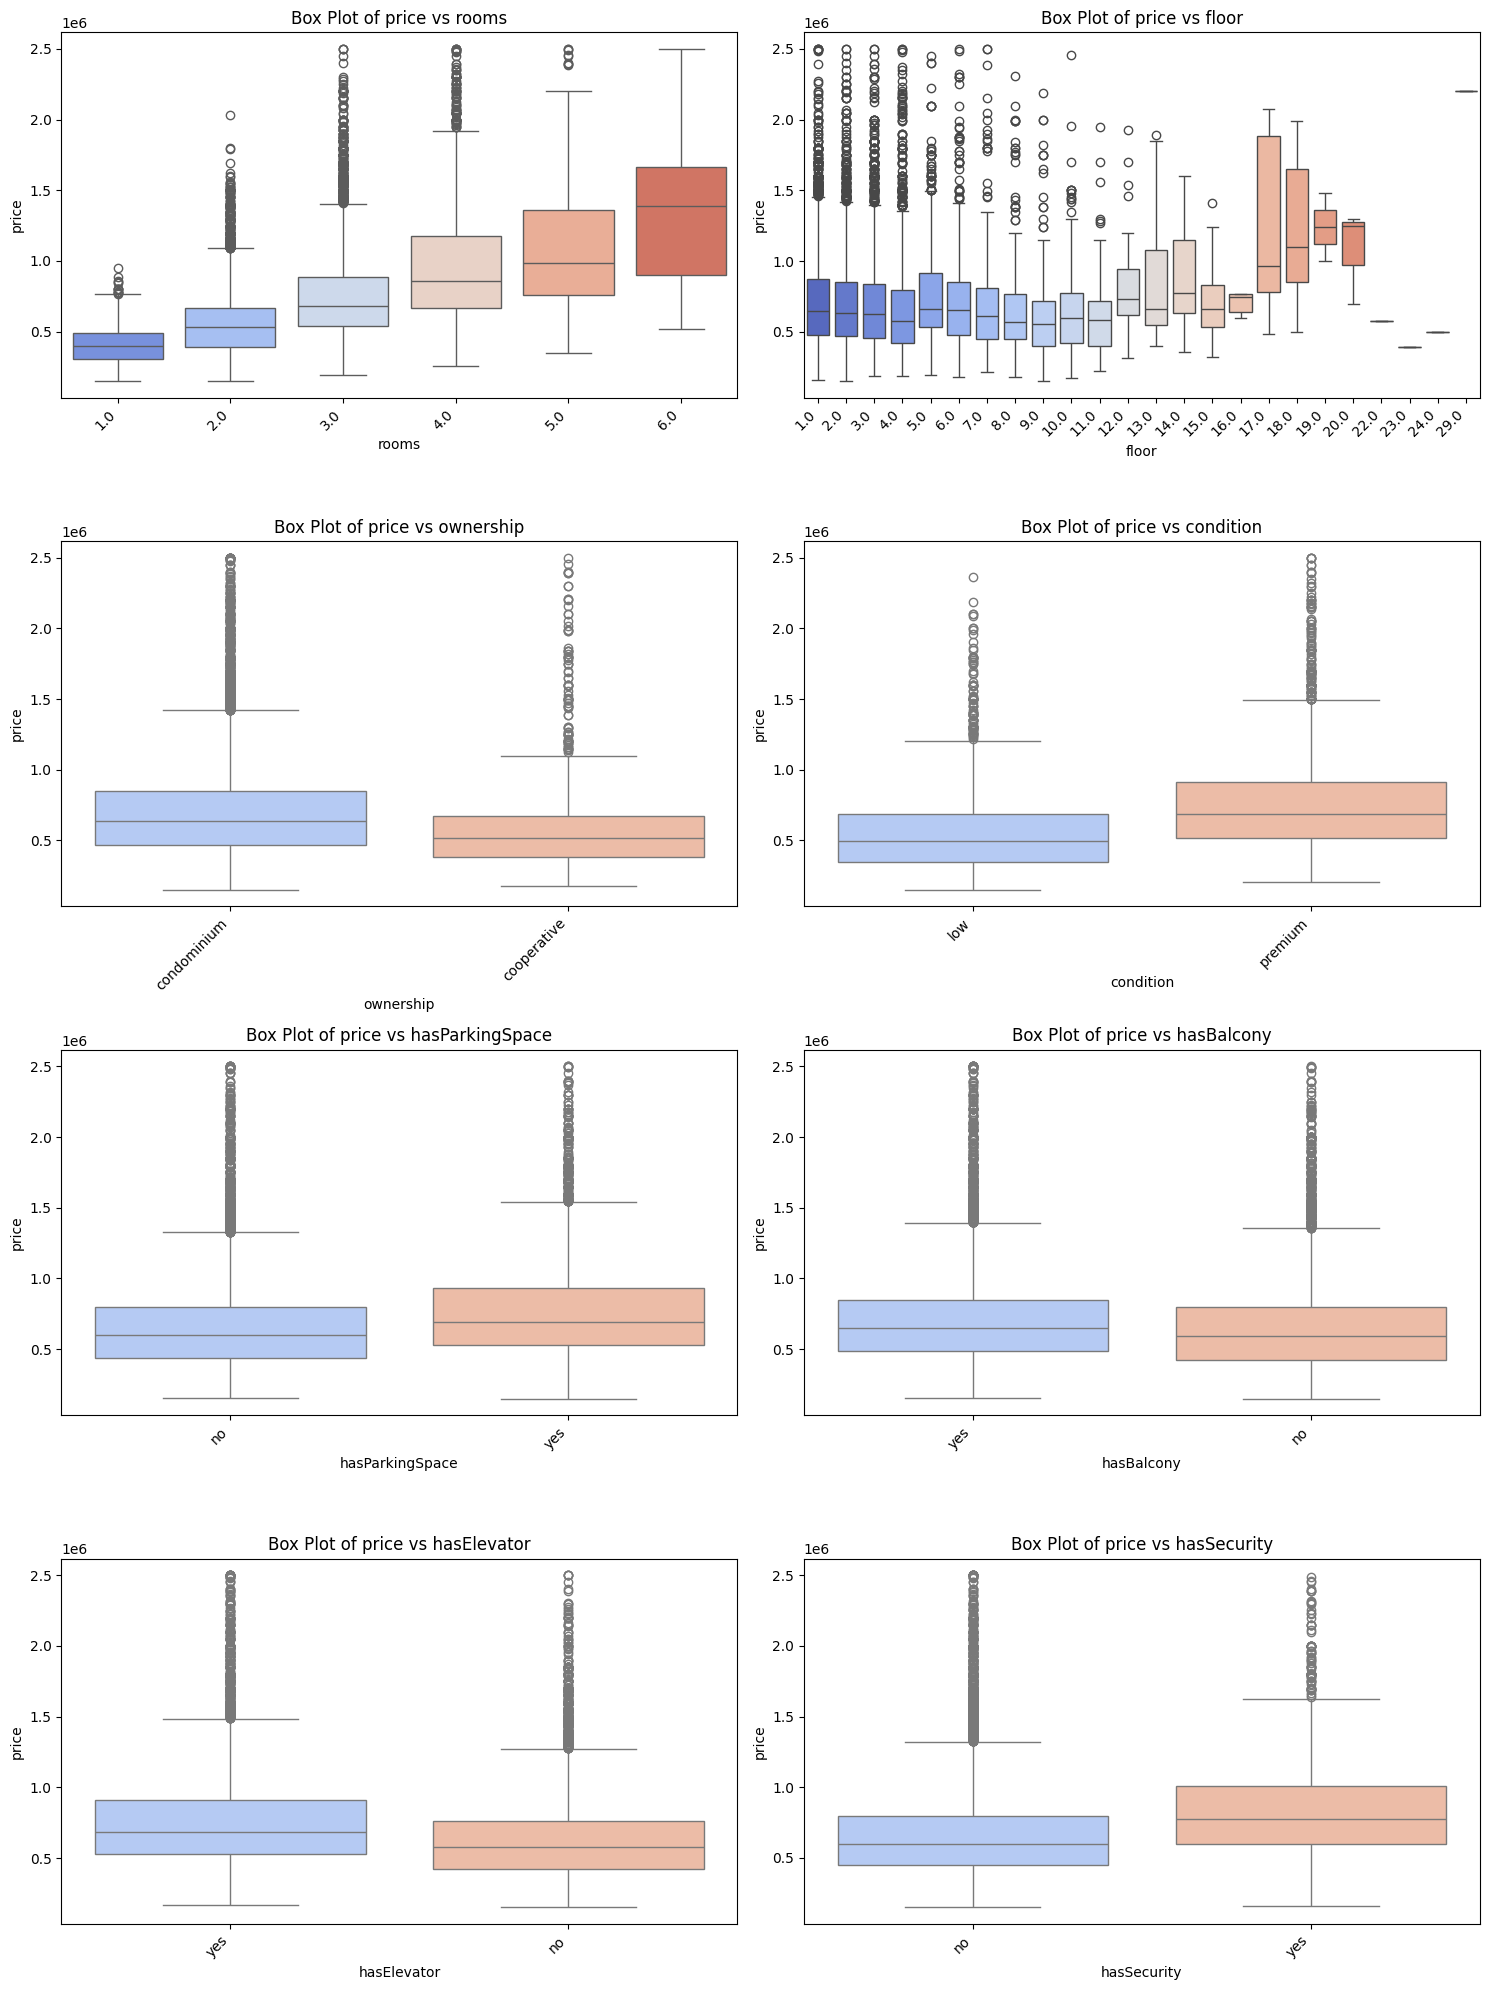

In [4]:
# Boxplots of price with categorical variables
plots.create_boxplot('price', ['rooms', 'floor', 'ownership', 'condition', 'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity'], n_rows=4, n_cols=2)

The relationship between price and the majority of the variables is as expected - price increases with the number of rooms and floor number, and properties with security, elevators and parking spaces are typically more expensive.

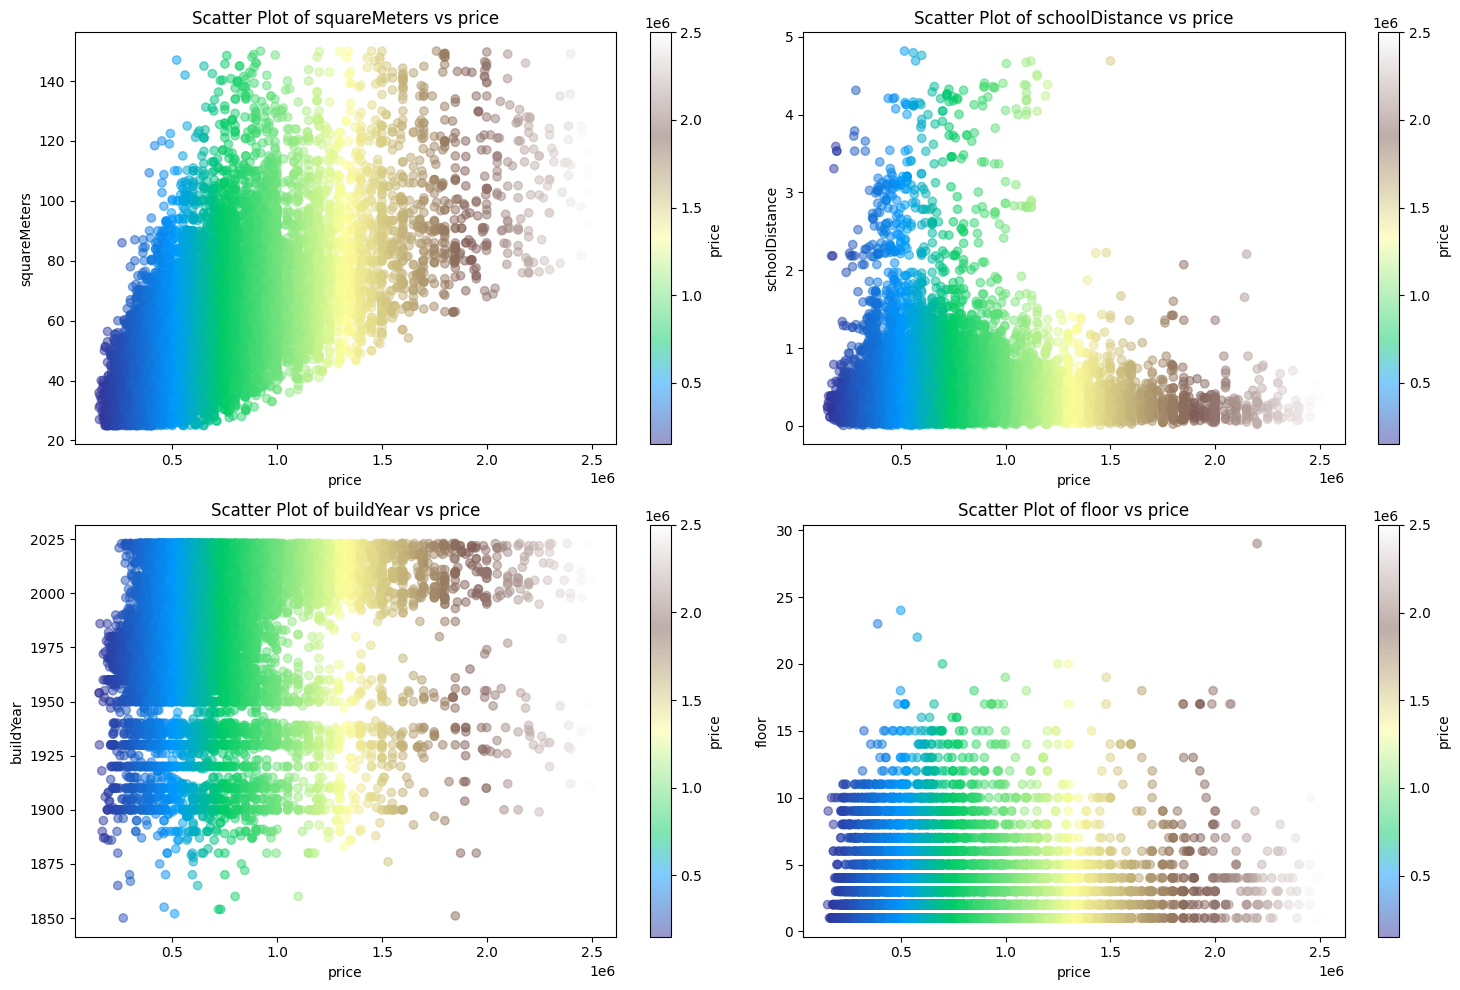

In [5]:
# Scatter plots
plots.create_scatter_plot([('price', 'squareMeters'), ('price', 'schoolDistance'), ('price', 'buildYear'), ('price', 'floor')], n_cols=2, n_rows=2)

The relationship between price and square meters is positive, while the correlation with the other variables is less obvious. There tends not to be expensive properties too far from a school or clinic, but for the lower price ranges the relationship is fairly weak. The relationship between price and the year the property was built is weakly positive.

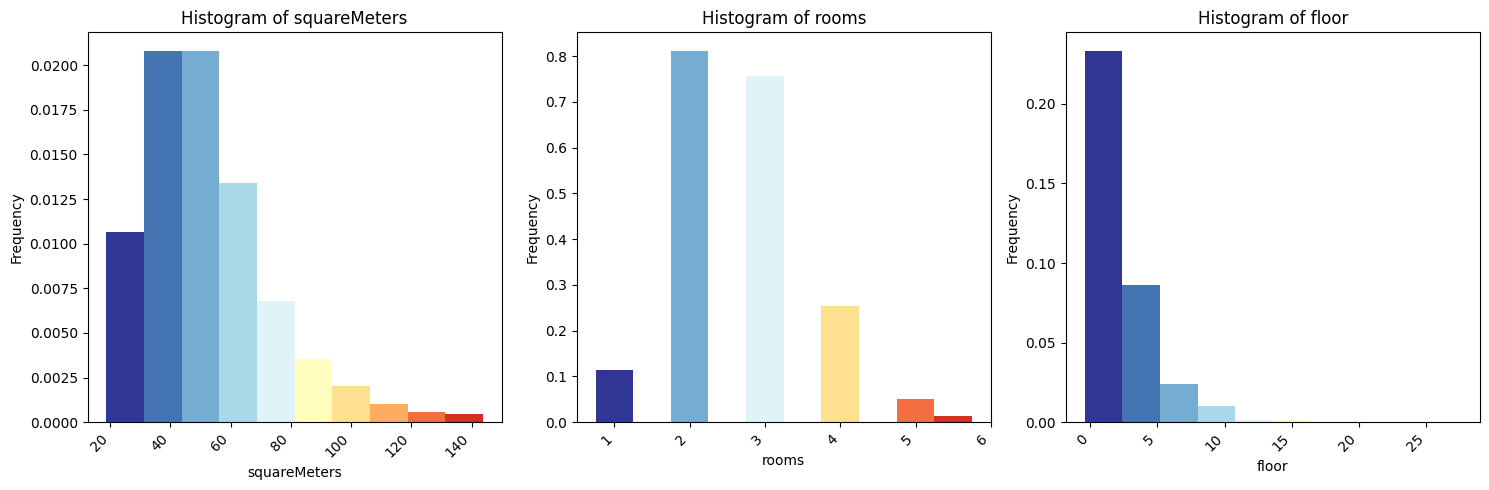

In [6]:
# Histograms
plots.create_histogram(['squareMeters', 'rooms', 'floor'])

The properties in our sample typically range in size from between 40 to 80 square meters, while the properties most commonly have either 2 or 3 rooms.

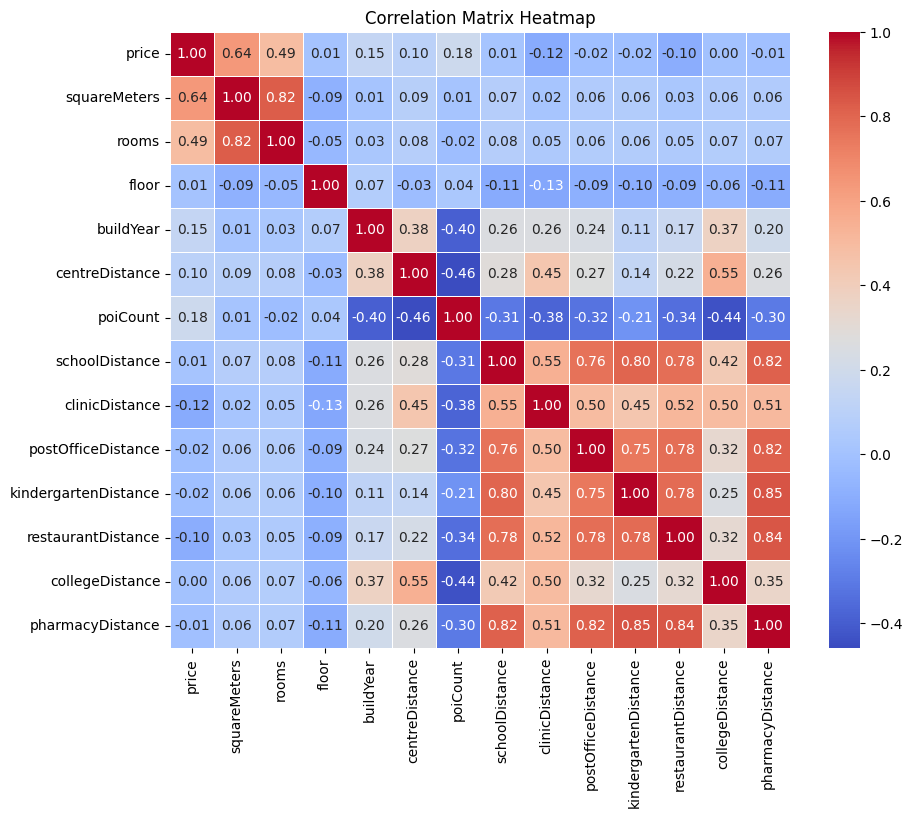

In [7]:
# Correlation matrix
corr = e.Correlation(all_data)
corr.visualize_data_correlation(['price', 'squareMeters', 'rooms', 'floor', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 
                                 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance'])

The two variables that exhibit the strongest correlation with price and square meters and the number of rooms. Consequentially, these are likely to be the best predictors of price in our model.

In [8]:
# Missing values analysis
miss = p.MissingValues(all_data)
missing_summary = miss.missing_values_summary()
missing_summary

,Missing Values,Percentage Missing
condition,14344,75.874107
buildingMaterial,7387,39.074319
type,4039,21.364718
floor,3438,18.185665
buildYear,3271,17.302301
hasElevator,926,4.898175
collegeDistance,565,2.988627
floorCount,262,1.385877
clinicDistance,88,0.465485
restaurantDistance,58,0.306797


Various variables have a significant amount of missing values, these will be dealt with when preprocessing the data.

### Data preprocessing

In [9]:
# Encoding binary variables
encoder = f.Encoding(all_data)

cols_to_encode = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom']
mapping_dictionary = {'yes': 1, 'no': 0}

all_data = encoder.mapping(cols_to_encode, mapping_dictionary)

In [10]:
# Checking unique values in type
all_data['type'].unique()

array(['blockOfFlats', 'tenement', nan, 'apartmentBuilding'], dtype=object)

Since type had over 20% of its values missing and we would like to use it in the model, we convert it to a numerical variable so it can be imputed with KNN. After this process we will convert type back to a categorical variable.

In [11]:
# Converting type to numerical so it can be imputed using KNN
encoder = f.Encoding(all_data)

mapping_dictionary = {'blockOfFlats': 1, 'tenement': 2, 'apartmentBuilding': 3}

all_data = encoder.mapping(['type'], mapping_dictionary)

In [12]:
# Dealing with missing values
miss_fill = p.MissingValues(all_data)

# Removing columns "condition" and "building_material" as there are so many missing values
miss_fill.remove_col(['condition', 'buildingMaterial'])

# Use KNN to impute all other missing values (arbitrarily use 5 neighbors) and return updated dataframe
all_data = miss_fill.impute_missing_knn(5)

In [13]:
# Check all missing values have been filled
all_data.isna().sum()

index                   0
id                      0
city                    0
type                    0
squareMeters            0
rooms                   0
floor                   0
floorCount              0
buildYear               0
latitude                0
longitude               0
centreDistance          0
poiCount                0
schoolDistance          0
clinicDistance          0
postOfficeDistance      0
kindergartenDistance    0
restaurantDistance      0
collegeDistance         0
pharmacyDistance        0
ownership               0
hasParkingSpace         0
hasBalcony              0
hasElevator             0
hasSecurity             0
hasStorageRoom          0
price                   0
is_train                0
dtype: int64

We now have no missing values, type needs to be converted back to a categorical variable after the KNN imputing

In [14]:
# Converting type back to categorical variable
encoder = f.Encoding(all_data)
all_data = encoder.return_closest_key('type', mapping_dictionary)

We now explore outliers in our data

In [15]:
# Define outliers class
outliers = p.Outliers(all_data)

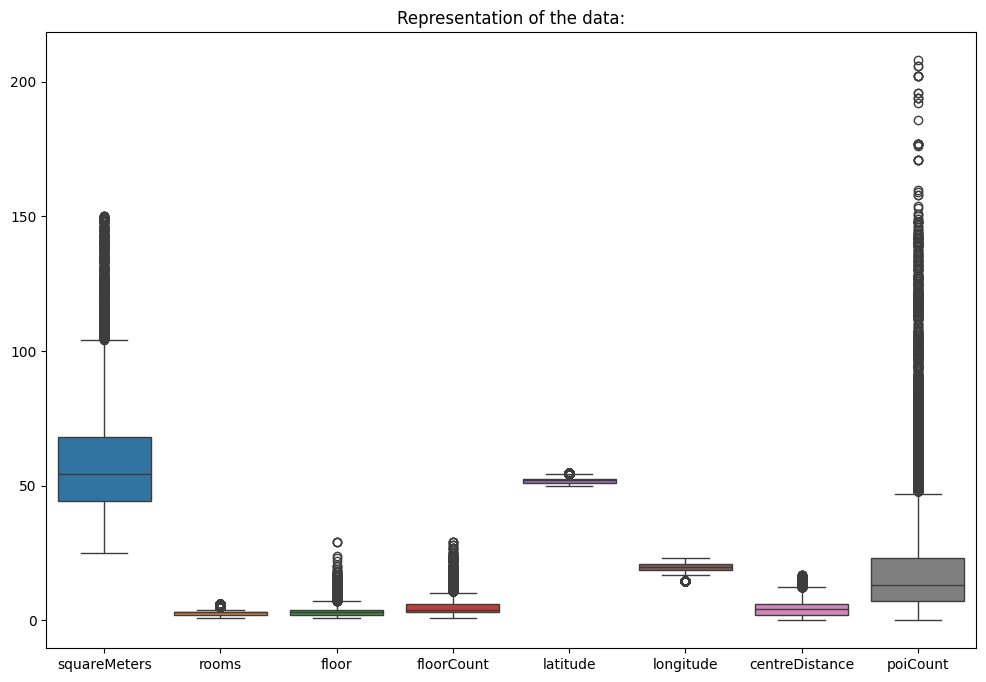

In [16]:
# Outlier handelling
columns_group_1 = ['squareMeters', 'rooms', 'floor', 'floorCount', 'latitude', 'longitude', 'centreDistance', 'poiCount']
# Plot outliers for the first group of numerical columns
outliers.plot_outliers(columns_group_1)

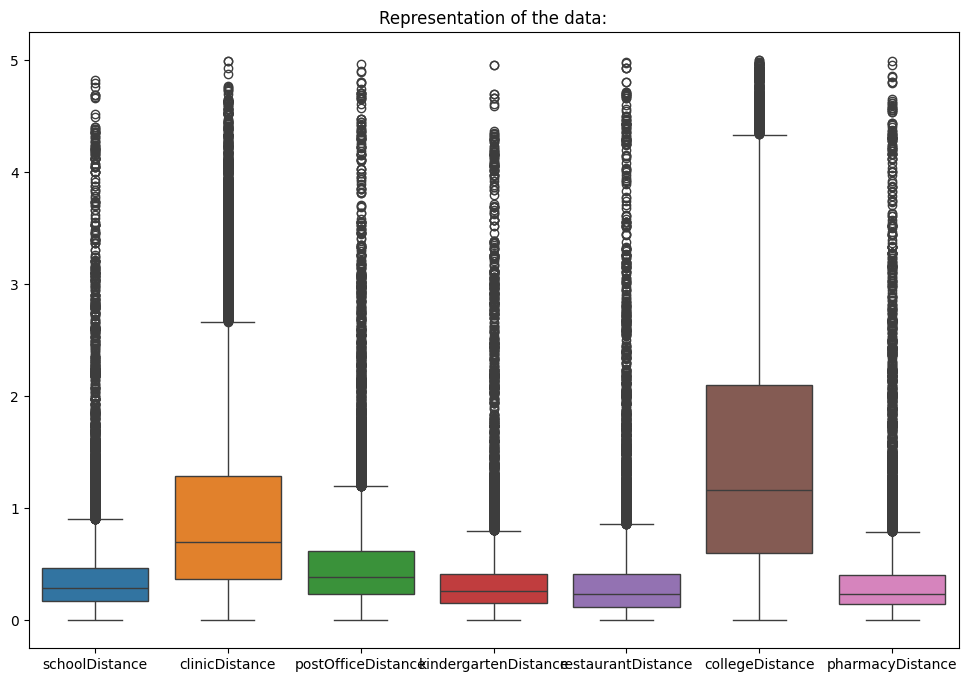

In [17]:
# Outlier handelling
columns_group_2 = ['schoolDistance',
       'clinicDistance', 'postOfficeDistance', 'kindergartenDistance',
       'restaurantDistance', 'collegeDistance', 'pharmacyDistance']
# Plot outliers for the second group of numerical columns
outliers.plot_outliers(columns_group_2)

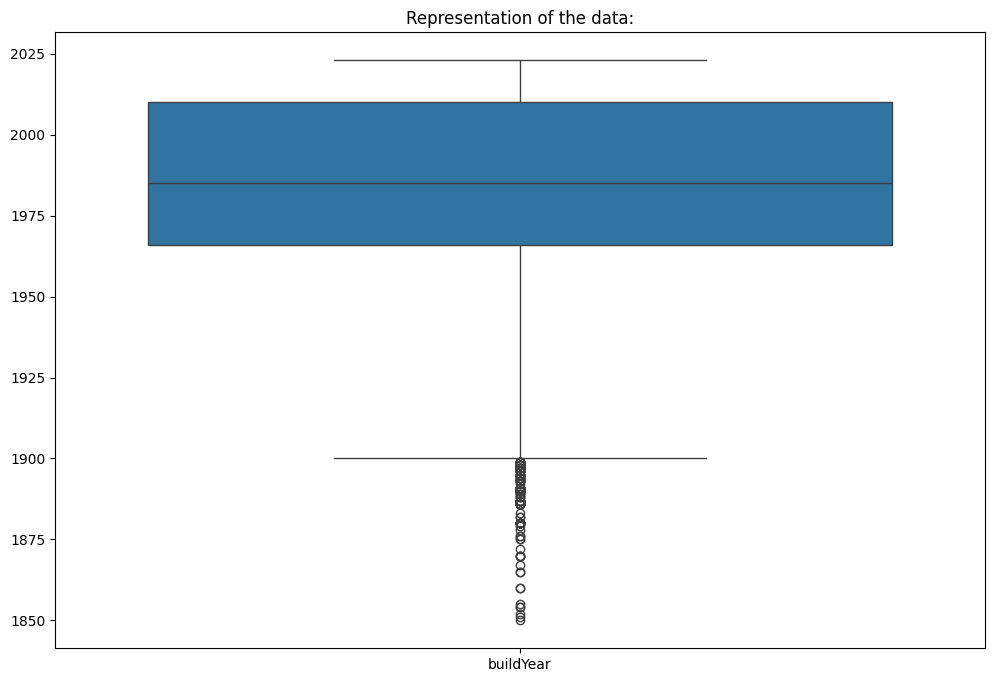

In [18]:
# Plot outliers for buildYear
outliers.plot_outliers(['buildYear'])

In [19]:
# Use standard deviation method to detect outliers
numeric_columns = all_data.select_dtypes(include=np.number).columns
outliers.detect_outliers(numeric_columns)

The number of outliers for index are 0.
The number of outliers for squareMeters are 737.
The number of outliers for rooms are 596.
The number of outliers for floor are 1698.
The number of outliers for floorCount are 1338.
The number of outliers for buildYear are 176.
The number of outliers for latitude are 1569.
The number of outliers for longitude are 552.
The number of outliers for centreDistance are 255.
The number of outliers for poiCount are 1840.
The number of outliers for schoolDistance are 1519.
The number of outliers for clinicDistance are 1477.
The number of outliers for postOfficeDistance are 1189.
The number of outliers for kindergartenDistance are 1243.
The number of outliers for restaurantDistance are 1239.
The number of outliers for collegeDistance are 381.
The number of outliers for pharmacyDistance are 1396.
The number of outliers for hasParkingSpace are 0.
The number of outliers for hasBalcony are 0.
The number of outliers for hasElevator are 0.
The number of outliers

In [20]:
# Winsorise numerical columns with outliers
cols_to_winsorize = ['squareMeters', 'rooms']
all_data = outliers.winsorize(cols_to_winsorize)

Winsorizing column squareMeters: Lower limit=31.65, Upper limit=100.0
Winsorizing column rooms: Lower limit=1.0, Upper limit=4.0


In [21]:
# Check ouliers after winsorizing
outliers.detect_outliers(numeric_columns)

The number of outliers for index are 0.
The number of outliers for squareMeters are 0.
The number of outliers for rooms are 0.
The number of outliers for floor are 1698.
The number of outliers for floorCount are 1338.
The number of outliers for buildYear are 176.
The number of outliers for latitude are 1569.
The number of outliers for longitude are 552.
The number of outliers for centreDistance are 255.
The number of outliers for poiCount are 1840.
The number of outliers for schoolDistance are 1519.
The number of outliers for clinicDistance are 1477.
The number of outliers for postOfficeDistance are 1189.
The number of outliers for kindergartenDistance are 1243.
The number of outliers for restaurantDistance are 1239.
The number of outliers for collegeDistance are 381.
The number of outliers for pharmacyDistance are 1396.
The number of outliers for hasParkingSpace are 0.
The number of outliers for hasBalcony are 0.
The number of outliers for hasElevator are 0.
The number of outliers for

We can see that in the above output after winsorizing there are no outliers for square meters or rooms.

### Feature engineering

Encoding variables: City, ownership and type

In [22]:
# Check unique values
print(all_data['city'].unique())
print(all_data['ownership'].unique())
print(all_data['type'].unique())

['bydgoszcz' 'gdansk' 'wroclaw' 'poznan' 'warszawa' 'krakow' 'lodz'
 'gdynia' 'lublin' 'szczecin' 'bialystok' 'czestochowa' 'rzeszow'
 'katowice' 'radom']
['condominium' 'cooperative']
['blockOfFlats' 'tenement' 'apartmentBuilding']


Ownership can just become a binary variable, while we will one-hot encode city and type, as there is no sensible variable to use for target encoding in this case.

In [23]:
# Converting ownership column to binary
encoder = f.Encoding(all_data)
mapping_dictionary = {'condominium': 1, 'cooperative': 0}
encoder.mapping(['ownership'], mapping_dictionary)


# One-hot encoding city and type
all_data = encoder.one_hot_encoding('city')
all_data = encoder.one_hot_encoding('type')

Adding city centre dummy and first floor dummy

In [24]:
all_data = encoder.lower_floors(2)
all_data = encoder.center_apartments(2)

The below function accesses Open-Meteo API, whereby we can use the latitude and longitude of the property to retrieve information about the weather in the local area. The function retrieves the following:

1. Maximum temperature
2. Minimum temperature
3. Average temperature
4. Maximum precipitation
5. Total precipitation
6. Number of rainy days
7. Maximum wind speed

In [25]:
# Adding weather features based on latitude and longitude
weather = f.WeatherFeatures(all_data)
all_data = weather.obtain_weather()

Adding square meters per room

In [26]:
rate = f.Rate(all_data)
all_data = rate.transform('squareMeters', 'rooms')

Standardizing data

In [27]:
# Standardizing all numerical columns
standard = f.Standardizer(all_data)

cols_to_standardize = ['squareMeters', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance',
                       'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance']

all_data = standard.transform(cols_to_standardize)

### Modelling

In this section we will:
1. Initially test some different models on the data
2. Cross-validate the models to examine their relative performances
3. Perform hyperparameter tuning to improve the performance of the models

Every time we run a model we will evaluate its performance against the test data by calculating the mean squared error (MSE)

In [29]:
# Split data back into test and train
train_data = all_data.loc[all_data.is_train == 1]
test_data = all_data.loc[all_data.is_train == 0]

We will now run various models on our data to predict house prices. We will test a normal linear model, a lasso regression and a ridge regression.

In [30]:
# Define features to be included in the model
features = ['squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance',
            'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance', 'ownership', 'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 
            'hasStorageRoom', 'city_bydgoszcz', 'city_czestochowa', 'city_gdansk', 'city_gdynia', 'city_katowice', 'city_krakow', 'city_lodz', 'city_lublin', 
            'city_poznan', 'city_radom', 'city_rzeszow', 'city_szczecin', 'city_warszawa', 'city_wroclaw', 'type_blockOfFlats', 'type_tenement', 'avg_temp', 'total_precip', 'rainy_days', 'max_wind',
            'type_blockOfFlats', 'type_tenement', 'rate', 'lower_floor', 'center_apartments']

In [31]:
# Linear model
lin_model = LinearRegression()
lin_model_runner = m.Model(features, 'price', lin_model)
lin_model_runner.train(train_data)
lin_predict = lin_model_runner.predict(test_data)
lin_model_runner.accuracy(test_data, lin_predict)

29998676838.243942

In [32]:
# LASSO model (default alpha = 1)
lasso_model = Lasso()
lasso_model_runner = m.Model(features, 'price', lasso_model)
lasso_model_runner.train(train_data)
lasso_predict = lasso_model_runner.predict(test_data)
lasso_model_runner.accuracy(test_data, lasso_predict)

30000943841.160736

In [33]:
# Ridge model (default alpha = 1)
ridge_model = Ridge()
ridge_model_runner = m.Model(features, 'price', ridge_model)
ridge_model_runner.train(train_data)
ridge_predict = ridge_model_runner.predict(test_data)
ridge_model_runner.accuracy(test_data, ridge_predict)

29998642999.00515

Performing cross-validation for the three models

In [34]:
# Cross-validation
models = {'Linear model': lin_model, 'LASSO model': lasso_model, 'Ridge model': ridge_model}

for model_name, model in models.items():
    cross_val = m.CrossValidation(features, 'price', model)
    print('\n')
    print("Results for " + model_name + ":")
    cross_val.regression_accuracy(train_data)
    



Results for Linear model:
Cross-validation results:
[3.18328849e+10 2.86152641e+10 2.90495929e+10 3.28373822e+10
 2.78353785e+10]
Mean squared error: 30034100523.43 +/- 1944774755.13


Results for LASSO model:
Cross-validation results:
[3.18348347e+10 2.86030152e+10 2.90517031e+10 3.28422681e+10
 2.78386714e+10]
Mean squared error: 30034098513.00 +/- 1947381187.90


Results for Ridge model:
Cross-validation results:
[3.18397560e+10 2.85951840e+10 2.90545001e+10 3.28422015e+10
 2.78425867e+10]
Mean squared error: 30034845683.65 +/- 1948263369.65


LASSO and Ridge both take an alpha value determining the optimal level of regularization. We now tune this parameter to try to improve the performance of the models.

In [35]:
# Finding best alpha
tuner = m.HyperparameterTuning(features, 'price')
best_alpha_lasso, min_mse_lasso, best_alpha_ridge, min_mse_ridge = tuner.find_best_alpha(train_data)

In [36]:
print("Best alpha LASSO: " + str(best_alpha_lasso))
print("LASSO MSE: " + str(min_mse_lasso))
print("Best alpha Ridge: " + str(best_alpha_ridge))
print("Ridge MSE: " + str(min_mse_ridge))

Best alpha LASSO: 1e-10
LASSO MSE: 29136895403.597965
Best alpha Ridge: 1e-10
Ridge MSE: 29135343868.007145


After hyperparameter tuning, Ridge regression returns the lowest MSE of the models. Below we train a Ridge and LASSO model with the best alpha parameters.

In [37]:
# Set up LASSO and Ridge models with optimal alphas
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model_runner = m.Model(features, 'price', lasso_model)
lasso_model_runner.train(train_data)

ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model_runner = m.Model(features, 'price', ridge_model)
ridge_model_runner.train(train_data)

Plot model coefficients

Linear Model Regression Formula:
1866450.81 + (251305.95 * squareMeters) + (-71103.14 * rooms) + (2693.31 * floor) + (-2130.09 * floorCount) + (25390.08 * buildYear) + (-56899.37 * centreDistance) + (29509.89 * poiCount) + (4606.99 * schoolDistance) + (-12671.98 * clinicDistance) + (4072.55 * postOfficeDistance) + (5709.54 * kindergartenDistance) + (-15680.86 * restaurantDistance) + (-8288.19 * collegeDistance) + (10404.50 * pharmacyDistance) + (18751.94 * ownership) + (15165.31 * hasParkingSpace) + (20813.86 * hasBalcony) + (49385.96 * hasElevator) + (20478.28 * hasSecurity) + (-16253.35 * hasStorageRoom) + (-209451.57 * city_bydgoszcz) + (-150664.54 * city_czestochowa) + (335489.61 * city_gdansk) + (307982.15 * city_gdynia) + (-119501.56 * city_katowice) + (68882.04 * city_krakow) + (-123546.09 * city_lodz) + (-71261.69 * city_lublin) + (-125997.06 * city_poznan) + (155879.32 * city_radom) + (-271177.48 * city_rzeszow) + (-171077.81 * city_szczecin) + (240176.53 * city_warszawa) + (-

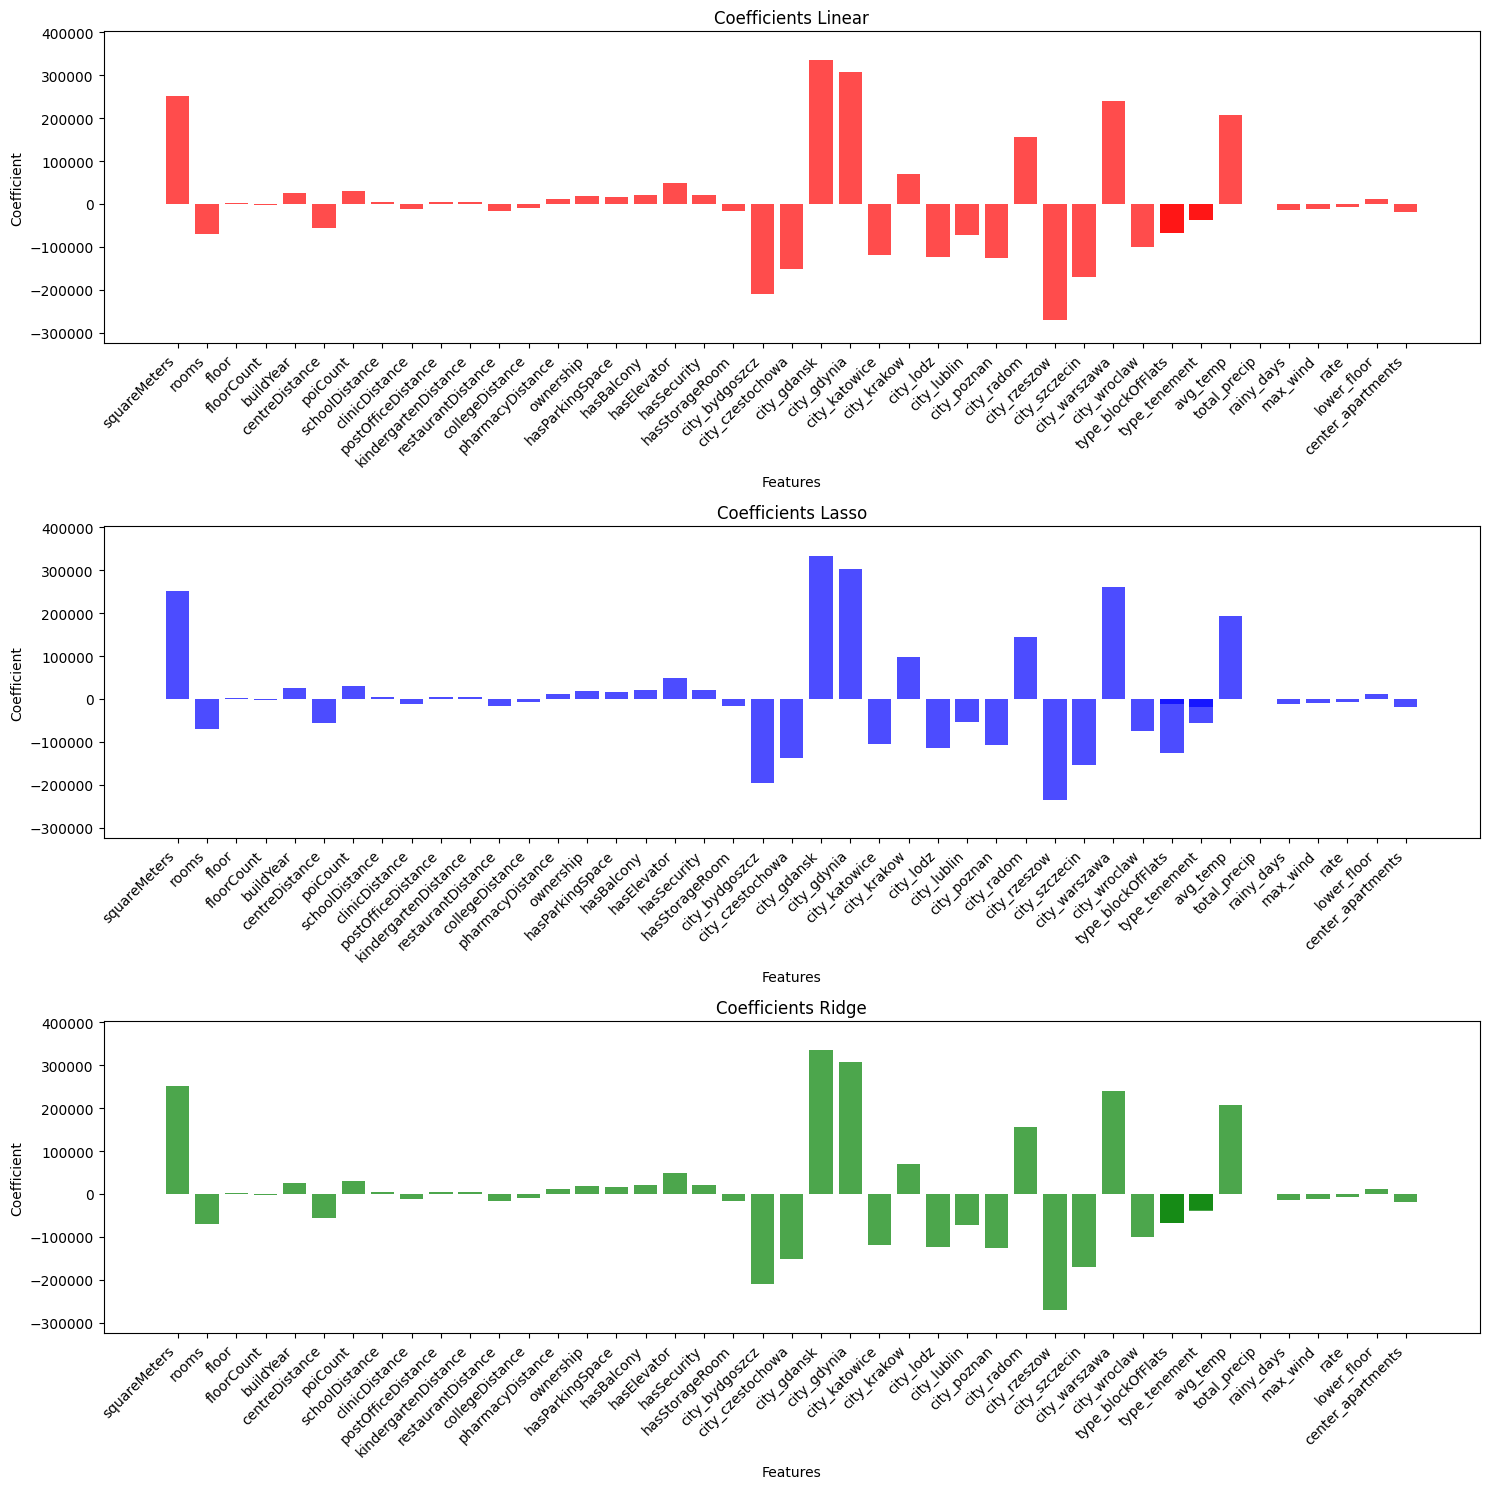

In [38]:
coef = m.ModelCoefficients()
coef.plot_coefficients(lin_model, lasso_model, ridge_model, all_data[features])

Overall the Ridge model performed the best at predicting house prices, with the lowest mean squared error of 29,135,343,868